In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
def parse_classification_report(file_path):
    """
    Parses a classification report text file and returns a DataFrame of metrics.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Process the relevant lines
    metrics = []
    for line in lines[2:]:  # Skip headers
        if line.strip() == "" or line.startswith("accuracy"):
            break
        parts = line.split()
        label = parts[0]
        precision, recall, f1_score, support = map(float, parts[1:5])
        metrics.append((label, precision, recall, f1_score, int(support)))
    
    return pd.DataFrame(metrics, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])


In [41]:
results_dir = "results/test/"
result_files = [os.path.join(results_dir, file) for file in os.listdir(results_dir) if file.endswith(".txt")]

# Parse each report into a dictionary of DataFrames
parsed_reports = {os.path.basename(file): parse_classification_report(file) for file in result_files}


In [42]:
comparison_df = pd.DataFrame()
for file_name, df in parsed_reports.items():
    df["Report"] = file_name  # Add the report name
    comparison_df = pd.concat([comparison_df, df], ignore_index=True)


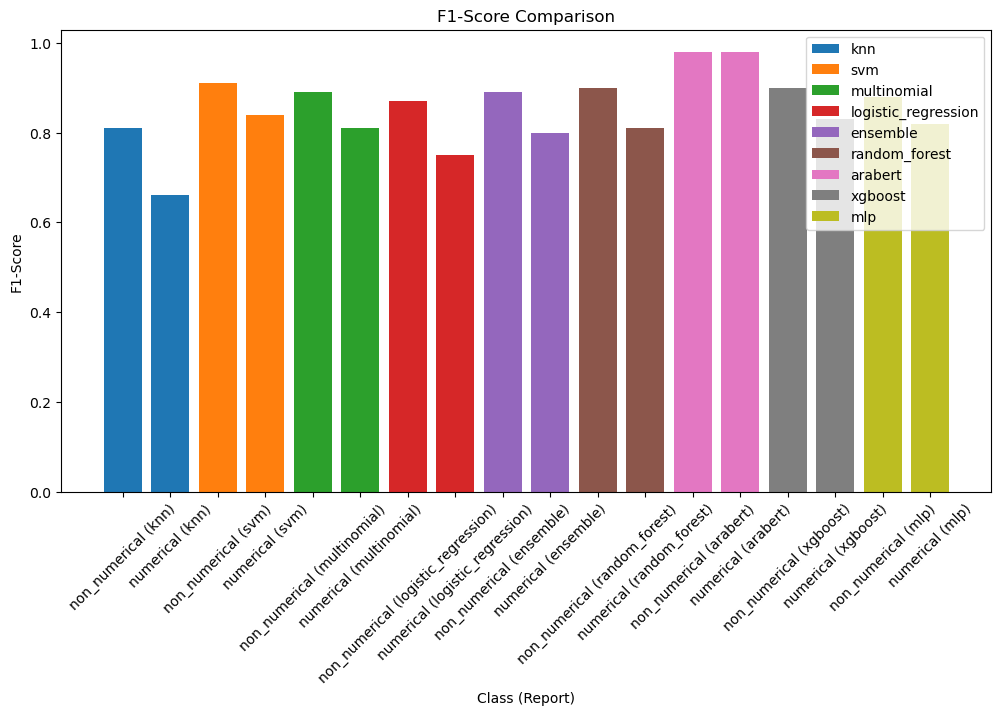

In [43]:
# Remove the '_classification_report.txt' suffix from the Report column
comparison_df["Report"] = comparison_df["Report"].str.replace("_report.txt", "")

# Bar Chart for F1-Scores with cleaned labels
plt.figure(figsize=(12, 6))
for report in comparison_df["Report"].unique():
    subset = comparison_df[comparison_df["Report"] == report]
    plt.bar(subset["Class"] + f" ({report})", subset["F1-Score"], label=report)

plt.title("F1-Score Comparison")
plt.ylabel("F1-Score")
plt.xlabel("Class (Report)")
plt.xticks(rotation=45)
plt.legend()
plt.show()


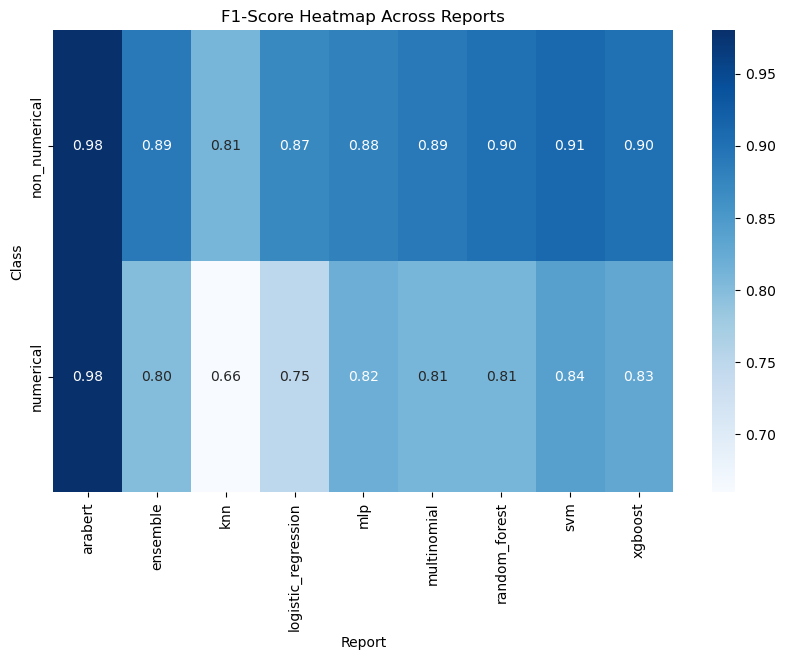

In [44]:
import seaborn as sns

pivot_table = comparison_df.pivot_table(
    values="F1-Score", index="Class", columns="Report", aggfunc="mean"
)  
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("F1-Score Heatmap Across Reports")
plt.ylabel("Class")
plt.xlabel("Report")
plt.show()


In [45]:
def parse_classification_report_with_overall_metrics(file_path):
    """
    Parses a classification report text file and extracts overall metrics
    such as accuracy, macro avg, and weighted avg.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    overall_metrics = {}

    for line in lines:
        line = line.strip()  # Remove extra whitespace
        if line.startswith("accuracy"):
            # Extract accuracy
            try:
                overall_metrics["Accuracy"] = float(line.split()[1])
            except (IndexError, ValueError):
                overall_metrics["Accuracy"] = None
        elif line.startswith("macro avg"):
            # Extract macro avg metrics
            parts = line.split()
            try:
                overall_metrics["Macro Precision"] = float(parts[-4])
                overall_metrics["Macro Recall"] = float(parts[-3])
                overall_metrics["Macro F1-Score"] = float(parts[-2])
            except (IndexError, ValueError):
                overall_metrics["Macro Precision"] = None
                overall_metrics["Macro Recall"] = None
                overall_metrics["Macro F1-Score"] = None
        elif line.startswith("weighted avg"):
            # Extract weighted avg metrics
            parts = line.split()
            try:
                overall_metrics["Weighted Precision"] = float(parts[-4])
                overall_metrics["Weighted Recall"] = float(parts[-3])
                overall_metrics["Weighted F1-Score"] = float(parts[-2])
            except (IndexError, ValueError):
                overall_metrics["Weighted Precision"] = None
                overall_metrics["Weighted Recall"] = None
                overall_metrics["Weighted F1-Score"] = None

    return overall_metrics


In [46]:
# Directory containing result files
results_dir = "results/test/"
result_files = [os.path.join(results_dir, file) for file in os.listdir(results_dir) if file.endswith(".txt")]

# Extract metrics for each file
overall_metrics = []
for file in result_files:
    metrics = parse_classification_report_with_overall_metrics(file)
    metrics["Report"] = os.path.basename(file).replace("_report.txt", "")  # Clean report name
    overall_metrics.append(metrics)

# Create DataFrame
overall_metrics_df = pd.DataFrame(overall_metrics)

In [47]:
overall_metrics_df

,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision,Weighted Recall,Weighted F1-Score,Report
0,0.76,0.76,0.73,0.74,0.76,0.76,0.75,knn
1,0.88,0.89,0.86,0.87,0.89,0.88,0.88,svm
2,0.86,0.88,0.84,0.85,0.87,0.86,0.86,multinomial
3,0.83,0.87,0.80,0.81,0.86,0.83,0.82,logistic_regression
4,0.86,0.89,0.84,0.85,0.88,0.86,0.86,ensemble
5,0.87,0.89,0.84,0.85,0.88,0.87,0.86,random_forest
6,0.98,0.98,0.98,0.98,0.98,0.98,0.98,arabert
7,0.87,0.88,0.85,0.86,0.87,0.87,0.87,xgboost
8,0.86,0.85,0.85,0.85,0.86,0.86,0.86,mlp


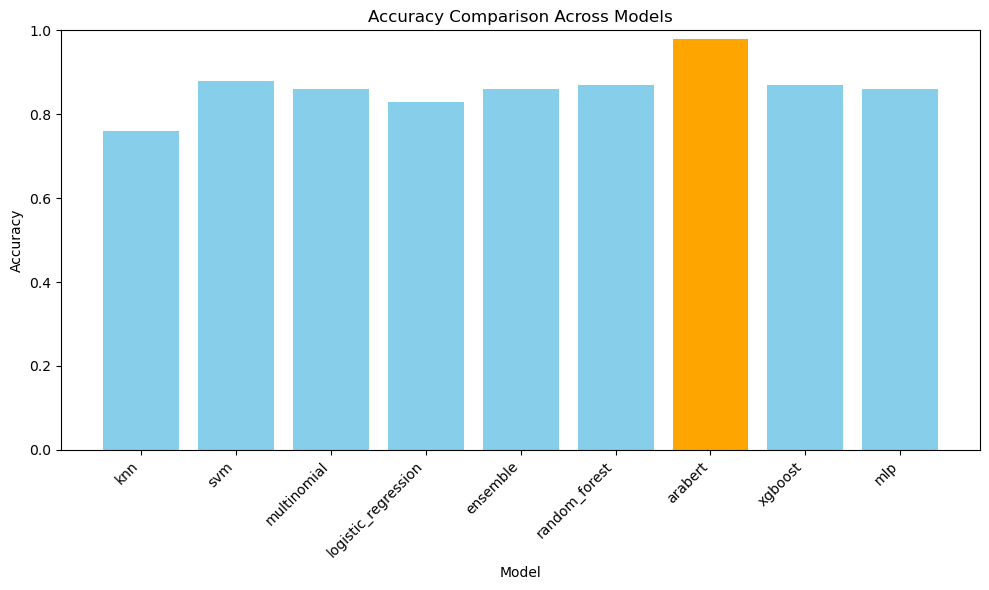

In [48]:
plt.figure(figsize=(10, 6))

# Get the index of the tallest bar
max_idx = overall_metrics_df["Accuracy"].idxmax()

# Set bar colors, with a unique color for the tallest bar
colors = ["skyblue" if i != max_idx else "orange" for i in range(len(overall_metrics_df))]

# Plot the bar chart
plt.bar(overall_metrics_df["Report"], overall_metrics_df["Accuracy"], color=colors)
plt.title("Accuracy Comparison Across Models")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.tight_layout()
plt.show()

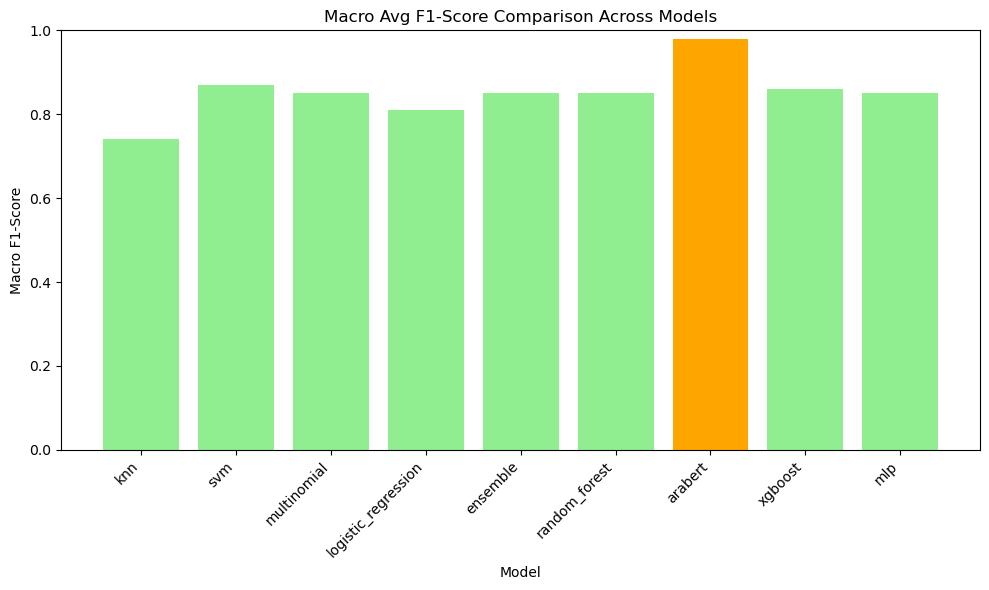

In [49]:
plt.figure(figsize=(10, 6))

# Get the index of the tallest bar
max_idx = overall_metrics_df["Macro F1-Score"].idxmax()

# Set bar colors, with a unique color for the tallest bar
colors = ["lightgreen" if i != max_idx else "orange" for i in range(len(overall_metrics_df))]

# Plot the bar chart
plt.bar(overall_metrics_df["Report"], overall_metrics_df["Macro F1-Score"], color=colors)
plt.title("Macro Avg F1-Score Comparison Across Models")
plt.ylabel("Macro F1-Score")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()